# Making stacked histograms
- processes an `events[year][ch][sample]` object using `make_events_dict()`
- uses `plot_hists()` to make stacked histograms

In [4]:
import glob
import os
import json
import pickle
import yaml
import math

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
luminosity

{'ele': {'Run2': 137640.0,
  '2016APV': 19492.72,
  '2016': 16809.96,
  '2017': 41476.02,
  '2018': 59816.23},
 'mu': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'lep': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'had': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96}}

In [7]:
def get_lumi(years, channels):
    lum_ = 0
    for year in years:
        lum = 0
        for ch in channels:
            lum += luminosity[ch][year] / 1000.0

        lum_ += lum / len(channels)    
    return lum_

In [8]:
def rename_column(ev_dict, old_name, new_name):
    for year in ev_dict:
        for ch in ev_dict[year]:
            for sample in ev_dict[year][ch]:
                df = ev_dict[year][ch][sample]
                df[new_name] = df[old_name]
                
                # drop old column
                df = df[df.columns.drop(list(df.filter(regex=old_name)))]

# tagger_old = "fj_ParT_score_finetuned_v2_1-12"
# tagger_new = "fj_ParT_score_finetuned_v2_1_12"
# rename_column(events_dict, tagger_old, tagger_new)                

In [234]:
 # define your regions here
presel = {
        "mu": {
#             "tagger>0.75": "fj_ParT_score_finetuned>0.75",
            "msoftdrop": "fj_mass>40",
#             "met": "met_pt>35",            
        },
        "ele": {
#             "tagger>0.75": "fj_ParT_score_finetuned>0.75",
            "msoftdrop": "fj_mass>40",
#             "met": "met_pt>55",
            "lepmiso": "(lep_pt<120) | ( (lep_pt>120) & (lep_misolation<0.025))",            
        },
}

from make_stacked_hists_tagger import make_events_dict
channels = ["ele", "mu"]
# channels = ["ele"]
samples = [
    "ggF", 
    "VBF",  
    "WH",
    "ZH",    
    "ttH",
    "QCD",
    "WJetsLNu",
    "TTbar",
    "SingleTop",
    "Diboson",
    "EWKvjets",    
    "Data",
    "WZQQorDYJets"
]

samples_dir = {
    "2016":    "../eos/Feb9_2016",
    "2016APV": "../eos/Feb9_2016APV",
    "2017":    "../eos/Feb9_2017",
    "2018":    "../eos/Feb9_2018",    
}

years = ["2017", "2016", "2016APV", "2018"]
# years = ["2018"]

In [235]:
events_dict = {}

In [236]:
taggers = [
#     "v2_nor2",     # old signal samples (irreproducible)
    
#     "v35_12_14",     # new signal samples (more reproducible)

#     "v35_16",    # new signal samples (very reproducible) 15 epochs
#     "v35_17",    # new signal samples (very reproducible) 15 epochs
    
    "v35_20",    # new signal samples (very reproducible) 25 epochs
    "v35_23",    # new signal samples (very reproducible) 25 epochs
    "v35_26",    # new signal samples (very reproducible) 25 epochs
    "v35_29",    # new signal samples (very reproducible) 25 epochs
    
    
    # with in-memory
#     "v35_21",    # new signal samples (very reproducible)
#     "v35_22",    # new signal samples (very reproducible)
#     "v35_23",    # new signal samples (very reproducible)
    
    
#     "v35_24",    # new signal samples (very reproducible)
]


for year in years:
    out = make_events_dict([year], channels, samples_dir[year], samples, presel, taggers)
    events_dict = {**events_dict, **out}

INFO:root:Finding VBFHToWWToAny_M-125_TuneCP5_withDipoleRecoil samples and should combine them under VBF
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 1663 events
INFO:root:Applying lepmiso selection on 1414 events
INFO:root:Will fill the VBF dataframe with the remaining 1372 events
INFO:root:tot event weight 11.29427288418148 

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 69 events
INFO:root:Applying lepmiso selection on 25 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 25 events
INFO:root:tot event weight 40.54625806302106 

INFO:root:Finding EWKWminus_WToLNu samples and should combine them under EWKvjets
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 1897 events
INFO:root:Applying lepmiso selection on 1453 events
INFO:root:Will fill the EWKvj

Skipping sample VBFHToWWToLNuQQ_M-125_withDipoleRecoil


INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 111882 events
INFO:root:Applying lepmiso selection on 105926 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 103998 events
INFO:root:tot event weight 5581.407762919806 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 355362 events
INFO:root:Applying lepmiso selection on 337566 events
INFO:root:Will fill the TTbar dataframe with the remaining 332338 events
INFO:root:tot event weight 37886.82713094477 

INFO:root:Finding ST_t-channel_top_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 23539 events
INFO:root:Applying lepmiso selection on 22660 events
INFO:root:Will fill the SingleTop dataframe with the remaining 22321 events
INFO:root:tot event weigh

INFO:root:Finding WW samples and should combine them under Diboson
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 876 events
INFO:root:Applying lepmiso selection on 661 events
INFO:root:Will fill the Diboson dataframe with the remaining 646 events
INFO:root:tot event weight 302.0540579260879 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-250To400 samples and should combine them under WZQQorDYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 530278 events
INFO:root:Applying lepmiso selection on 465284 events
INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 459140 events
INFO:root:tot event weight 2313.705429216987 

INFO:root:Finding ST_t-channel_antitop_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 9552 events
INFO:root:Applying lepmiso selection on 9183 events
INFO:root:Wi

INFO:root:tot event weight 32.623801536477984 

INFO:root:Finding EWKWplus_WToLNu samples and should combine them under EWKvjets
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 1493 events
INFO:root:Applying lepmiso selection on 1154 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 1134 events
INFO:root:tot event weight 468.9523073703374 

INFO:root:Finding GluGluZH_HToWW_M-125_TuneCP5_13TeV-powheg-pythia8 samples and should combine them under ZH
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 10580 events
INFO:root:Applying lepmiso selection on 9174 events
INFO:root:Will fill the ZH dataframe with the remaining 8955 events
INFO:root:tot event weight 0.10986611255877264 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-0To50 samples and should combine them under WZQQorDYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 623 events
INFO:root:Ap

Skipping sample VBFHToWWToLNuQQ_M-125_withDipoleRecoil


INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 148852 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 137181 events
INFO:root:tot event weight 7463.416563968551 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 375217 events
INFO:root:Will fill the TTbar dataframe with the remaining 349016 events
INFO:root:tot event weight 39668.85529541071 

INFO:root:Finding ST_t-channel_top_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 34606 events
INFO:root:Will fill the SingleTop dataframe with the remaining 32700 events
INFO:root:tot event weight 890.746924887893 

INFO:root:Finding ST_s-channel_4f_hadronicDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event w

INFO:root:Will fill the TTbar dataframe with the remaining 97691 events
INFO:root:tot event weight 3233.2191987422216 

INFO:root:Finding QCD_Pt_2400to3200 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 149 events
INFO:root:Will fill the QCD dataframe with the remaining 126 events
INFO:root:tot event weight 0.00866791787427749 

INFO:root:Finding EWKZ_ZToQQ samples and should combine them under EWKvjets
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 63 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 54 events
INFO:root:tot event weight 2.015102790366754 

INFO:root:Finding ZJetsToQQ_HT-400to600 samples and should combine them under WZQQorDYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 61 events
INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 50 events
INFO:root:tot event

INFO:root:tot event weight 1.3181954830106117 

INFO:root:Finding SingleMuon_Run2017F samples and should combine them under Data
INFO:root:Applying msoftdrop selection on 35806 events
INFO:root:Will fill the Data dataframe with the remaining 29674 events
INFO:root:tot event weight 29674.0 

INFO:root:Finding VBFHToWWToAny_M-125_TuneCP5_withDipoleRecoil samples and should combine them under VBF
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 784 events
INFO:root:Applying lepmiso selection on 677 events
INFO:root:Will fill the VBF dataframe with the remaining 656 events
INFO:root:tot event weight 4.960842529930631 

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 16 events
INFO:root:Applying lepmiso selection on 11 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 11 events
INFO:root:tot event weig

Skipping sample VBFHToWWToLNuQQ_M-125_withDipoleRecoil


INFO:root:Applying msoftdrop selection on 42945 events
INFO:root:Applying lepmiso selection on 40676 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 39871 events
INFO:root:tot event weight 2260.30191255103 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 353131 events
INFO:root:Applying lepmiso selection on 335999 events
INFO:root:Will fill the TTbar dataframe with the remaining 330746 events
INFO:root:tot event weight 14959.9688004136 

INFO:root:Finding SingleElectron_Run2016G samples and should combine them under Data
INFO:root:Applying msoftdrop selection on 17638 events
INFO:root:Applying lepmiso selection on 15243 events
INFO:root:Will fill the Data dataframe with the remaining 14620 events
INFO:root:tot event weight 14620.0 

INFO:root:Finding ST_t-channel_top_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:-

INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 221409 events
INFO:root:tot event weight 992.3900227254197 

INFO:root:Finding ST_t-channel_antitop_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 3760 events
INFO:root:Applying lepmiso selection on 3625 events
INFO:root:Will fill the SingleTop dataframe with the remaining 3565 events
INFO:root:tot event weight 103.54407921203344 

INFO:root:Finding TTTo2L2Nu samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 64280 events
INFO:root:Applying lepmiso selection on 61111 events
INFO:root:Will fill the TTbar dataframe with the remaining 60142 events
INFO:root:tot event weight 1629.1691847826442 

INFO:root:Finding QCD_Pt_2400to3200 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:App

INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 353 events
INFO:root:Applying lepmiso selection on 345 events
INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 345 events
INFO:root:tot event weight 97.83750983490452 

INFO:root:Finding WJetsToQQ_HT-400to600 samples and should combine them under WZQQorDYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 33 events
INFO:root:Applying lepmiso selection on 28 events
INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 24 events
INFO:root:tot event weight 32.92044033850409 

INFO:root:Finding WJetsToLNu_HT-400To600 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 11726 events
INFO:root:Applying lepmiso selection on 10247 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 10097 events
INFO:root:tot event weight 5178.372763

Skipping sample VBFHToWWToLNuQQ_M-125_withDipoleRecoil


INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 60046 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 55372 events
INFO:root:tot event weight 3146.9473511722235 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 393726 events
INFO:root:Will fill the TTbar dataframe with the remaining 367332 events
INFO:root:tot event weight 16262.872971674096 

INFO:root:Finding SingleElectron_Run2016G samples and should combine them under Data
INFO:root:Finding ST_t-channel_top_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 16348 events
INFO:root:Will fill the SingleTop dataframe with the remaining 15497 events
INFO:root:tot event weight 359.22253271067245 

INFO:root:Finding ST_s-channel_4f_hadronicDecays samp

INFO:root:tot event weight 12.293955433640926 

INFO:root:Finding ZZ samples and should combine them under Diboson
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 32 events
INFO:root:Will fill the Diboson dataframe with the remaining 24 events
INFO:root:tot event weight 5.289036187026934 

INFO:root:Finding TTToHadronic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 1629 events
INFO:root:Will fill the TTbar dataframe with the remaining 1543 events
INFO:root:tot event weight 93.87336542693461 

INFO:root:Finding QCD_Pt_1000to1400 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 1233 events
INFO:root:Will fill the QCD dataframe with the remaining 1061 events
INFO:root:tot event weight 6.568133330625931 

INFO:root:Finding QCD_Pt_600to800 samples and should combine them under Q

INFO:root:tot event weight 199.1082711856596 

INFO:root:Finding EWKZ_ZToNuNu samples and should combine them under EWKvjets
INFO:root:Finding HWminusJ_HToWW_M-125 samples and should combine them under WH
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 1032 events
INFO:root:Applying lepmiso selection on 880 events
INFO:root:Will fill the WH dataframe with the remaining 858 events
INFO:root:tot event weight 0.6561964956237026 

INFO:root:Finding WJetsToLNu_HT-800To1200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight


Skipping sample VBFHToWWToLNuQQ_M-125_withDipoleRecoil


INFO:root:Applying msoftdrop selection on 50985 events
INFO:root:Applying lepmiso selection on 48381 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 47488 events
INFO:root:tot event weight 2448.343067868354 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 326351 events
INFO:root:Applying lepmiso selection on 310902 events
INFO:root:Will fill the TTbar dataframe with the remaining 306019 events
INFO:root:tot event weight 15940.594081293411 

INFO:root:Finding ST_t-channel_top_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 9112 events
INFO:root:Applying lepmiso selection on 8823 events
INFO:root:Will fill the SingleTop dataframe with the remaining 8684 events
INFO:root:tot event weight 261.117660955312 

INFO:root:Finding ST_s-channel_4f

INFO:root:tot event weight 1744.5446040437448 

INFO:root:Finding QCD_Pt_2400to3200 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 231 events
INFO:root:Applying lepmiso selection on 181 events
INFO:root:Will fill the QCD dataframe with the remaining 160 events
INFO:root:tot event weight 0.005197298722038595 

INFO:root:Finding SingleElectron_Run2016E_HIPM samples and should combine them under Data
INFO:root:Applying msoftdrop selection on 8612 events
INFO:root:Applying lepmiso selection on 7438 events
INFO:root:Will fill the Data dataframe with the remaining 7118 events
INFO:root:tot event weight 7118.0 

INFO:root:Finding EWKZ_ZToQQ samples and should combine them under EWKvjets
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 48 events
INFO:root:Applying lepmiso selection on 40 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 35 events
IN

INFO:root:tot event weight 217.34002095365028 

INFO:root:Finding GluGluZH_HToWW_M-125_TuneCP5_13TeV-powheg-pythia8 samples and should combine them under ZH
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 4863 events
INFO:root:Applying lepmiso selection on 4183 events
INFO:root:Will fill the ZH dataframe with the remaining 4083 events
INFO:root:tot event weight 0.04368465904669016 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-0To50 samples and should combine them under WZQQorDYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 344 events
INFO:root:Applying lepmiso selection on 332 events
INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 332 events
INFO:root:tot event weight 85.84918258468551 

INFO:root:Finding WJetsToQQ_HT-400to600 samples and should combine them under WZQQorDYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 44 events
INF

Skipping sample VBFHToWWToLNuQQ_M-125_withDipoleRecoil


INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 73854 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 68055 events
INFO:root:tot event weight 3524.310133706629 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 368486 events
INFO:root:Will fill the TTbar dataframe with the remaining 343964 events
INFO:root:tot event weight 17792.199484087836 

INFO:root:Finding ST_t-channel_top_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 13314 events
INFO:root:Will fill the SingleTop dataframe with the remaining 12623 events
INFO:root:tot event weight 381.8395540923992 

INFO:root:Finding ST_s-channel_4f_hadronicDecays samples and should combine them under SingleTop
INFO:root:Finding WJetsToLNu_HT-1200To2500 

INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 37 events
INFO:root:tot event weight 11.381884050211436 

INFO:root:Finding ZZ samples and should combine them under Diboson
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 37 events
INFO:root:Will fill the Diboson dataframe with the remaining 25 events
INFO:root:tot event weight 6.180524148959353 

INFO:root:Finding TTToHadronic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 1921 events
INFO:root:Will fill the TTbar dataframe with the remaining 1835 events
INFO:root:tot event weight 100.6792680219248 

INFO:root:Finding QCD_Pt_1000to1400 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 1127 events
INFO:root:Will fill the QCD dataframe with the remaining 969 events
INFO:root:tot event weight 7.154090752277115 

INFO:root:Applying msoftdrop selection on 414 events
INFO:root:Will fill the Diboson dataframe with the remaining 320 events
INFO:root:tot event weight 34.54590855411825 

INFO:root:Finding QCD_Pt_1400to1800 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 773 events
INFO:root:Will fill the QCD dataframe with the remaining 668 events
INFO:root:tot event weight 0.7118559192005918 

INFO:root:Finding SingleElectron_Run2016B_ver2_HIPM samples and should combine them under Data
INFO:root:Finding VBFHToWWToAny_M-125_TuneCP5_withDipoleRecoil samples and should combine them under VBF
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 1514 events
INFO:root:Applying lepmiso selection on 1308 events
INFO:root:Will fill the VBF dataframe with the remaining 1269 events
INFO:root:tot event weight 16.67635491325141 

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should c

Skipping sample VBFHToWWToLNuQQ_M-125_withDipoleRecoil


INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 159607 events
INFO:root:Applying lepmiso selection on 151377 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 148680 events
INFO:root:tot event weight 8296.239388961647 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 349864 events
INFO:root:Applying lepmiso selection on 332704 events
INFO:root:Will fill the TTbar dataframe with the remaining 327705 events
INFO:root:tot event weight 53336.20377853462 

INFO:root:Finding ST_t-channel_top_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 31158 events
INFO:root:Applying lepmiso selection on 30101 events
INFO:root:Will fill the SingleTop dataframe with the remaining 29680 events
INFO:root:tot event weigh

INFO:root:tot event weight 5888.4762718154825 

INFO:root:Finding QCD_Pt_2400to3200 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 222 events
INFO:root:Applying lepmiso selection on 185 events
INFO:root:Will fill the QCD dataframe with the remaining 151 events
INFO:root:tot event weight 0.01574902531269195 

INFO:root:Finding EWKZ_ZToQQ samples and should combine them under EWKvjets
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 1 events
INFO:root:Applying lepmiso selection on 1 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 1 events
INFO:root:tot event weight 3.9035559032617795 

INFO:root:Finding ZJetsToQQ_HT-400to600 samples and should combine them under WZQQorDYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 47 events
INFO:root:Applying lepmiso selection on 33 events
INFO:root:Will fil

INFO:root:Applying msoftdrop selection on 14086 events
INFO:root:Applying lepmiso selection on 12215 events
INFO:root:Will fill the ZH dataframe with the remaining 11913 events
INFO:root:tot event weight 0.1535097157555611 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-0To50 samples and should combine them under WZQQorDYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 885 events
INFO:root:Applying lepmiso selection on 841 events
INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 841 events
INFO:root:tot event weight 369.5260101959201 

INFO:root:Finding SingleMuon_Run2018C samples and should combine them under Data
INFO:root:Finding WJetsToQQ_HT-400to600 samples and should combine them under WZQQorDYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 58 events
INFO:root:Applying lepmiso selection on 40 events
INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 34 events


Skipping sample VBFHToWWToLNuQQ_M-125_withDipoleRecoil


INFO:root:Will fill the WH dataframe with the remaining 5747 events
INFO:root:tot event weight 4.099316558494143 

INFO:root:Finding WJetsToLNu_HT-800To1200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 210651 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 193890 events
INFO:root:tot event weight 11072.172054240289 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 366309 events
INFO:root:Will fill the TTbar dataframe with the remaining 340819 events
INFO:root:tot event weight 56228.32369707113 

INFO:root:Finding ST_t-channel_top_4f_InclusiveDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 44464 events
INFO:root:Will fill the SingleTop dataframe with the rema

INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 40 events
INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 32 events
INFO:root:tot event weight 23.198650290152685 

INFO:root:Finding ZZ samples and should combine them under Diboson
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 129 events
INFO:root:Will fill the Diboson dataframe with the remaining 94 events
INFO:root:tot event weight 24.57793390110879 

INFO:root:Finding TTToHadronic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 1386 events
INFO:root:Will fill the TTbar dataframe with the remaining 1320 events
INFO:root:tot event weight 289.2714592608931 

INFO:root:Finding QCD_Pt_1000to1400 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying msoftdrop selection on 1111 events
INFO:root:W

INFO:root:Will fill the QCD dataframe with the remaining 525 events
INFO:root:tot event weight 1.8335460679587459 

INFO:root:Finding SingleMuon_Run2018B samples and should combine them under Data
INFO:root:Applying msoftdrop selection on 16683 events
INFO:root:Will fill the Data dataframe with the remaining 14077 events
INFO:root:tot event weight 14077.0 



In [237]:
taggerss = ["fj_ParT_score"]
for tagger in taggers:
    taggerss.append(f"fj_ParT_score_finetuned_{tagger}")

In [241]:
signals = ["VBF", "ggF"]
# signals += ["ttH", "WH", "ZH"]

# tagger_cuts = np.linspace(0.8, 0.97, 30)
tagger_cuts = np.linspace(0.8, 1, 61)

years = ["2017", "2018", "2016", "2016APV"]
# years = ["2018"]
channels = ["ele", "mu"]
# channels = ["ele"]

s_over_b = {}

den, num = 0, 0

taggers_to_plot = [
    "fj_ParT_score",
#     "fj_ParT_score_finetuned",
#     "fj_ParT_score_finetuned_v35_12_14",
    
#     "fj_ParT_score_finetuned_v35_16",
#     "fj_ParT_score_finetuned_v35_17",
#     "fj_ParT_score_finetuned_v35_20",    
    
    "fj_ParT_score_finetuned_v35_23",
    "fj_ParT_score_finetuned_v35_26",
    "fj_ParT_score_finetuned_v35_29",
    
#     "fj_ParT_score_finetuned_v35_24",
    

#     "fj_ParT_score_finetuned_v35_12_14 metcut",

#     "fj_ParT_score_finetuned_v35_12_14 met>25",
#     "fj_ParT_score_finetuned_v35_12_14 met>30",
#     "fj_ParT_score_finetuned_v35_12_14 met>35",
#     "fj_ParT_score_finetuned_v35_12_14 met>40",
#     "fj_ParT_score_finetuned_v35_12_14 met>45",
#     "fj_ParT_score_finetuned_v35_12_14 met>50",
#     "fj_ParT_score_finetuned_v35_12_14 met>55",
#     "fj_ParT_score_finetuned_v35_12_14 met>60",    
]

add_vbfcut = 0
add_ggFcut = 0

for tagger in taggers_to_plot:
        
    print("TAGGER:", tagger)
    s_over_b[tagger] = []

    for tagger_cut in tagger_cuts[:-3]:
        print("tagger cut", tagger_cut)
        s, b = 0, 0
        for year in years:
            for ch in channels:
                for sample in events_dict[year][ch]:
                    if sample =="Data":
                        continue
                    
                    df = events_dict[year][ch][sample]
                    
                    df = df[df[tagger]>tagger_cut]
                        
#                     df = df[df["fj_ParT_score_finetuned_v35_12_14"]>tagger_cut]

                    df = df[(df["n_bjets_T"]==0)]                    

                    # add mass window 
                    mass_window = [100, 150]
                    df = df[(df["rec_higgs_m"]>=mass_window[0]) & (df["rec_higgs_m"]<=mass_window[1])]
                    
#                     mass_window = [50, 150]
#                     df = df[(df["fj_mass"]>=mass_window[0]) & (df["fj_mass"]<=mass_window[1])]
                        
                    #add vbf cut
                    if add_vbfcut:
                        df = df[(df["mjj"]>1000) & (df["deta"]>3.5)]
                    if add_ggFcut:
                        df = df[(df["mjj"]<1000) | (df["deta"]<3.5)]

                    if sample == "QCD":
                        continue
                        
#                     if sample == "QCD":
#                         threshold = 30
#                         den += len(df['event_weight'])
#                         num += sum(df["event_weight"]>threshold)

#                         avg_good_weight = df["event_weight"][df["event_weight"]<threshold].mean()

#                         df["event_weight"][df["event_weight"]>threshold] = avg_good_weight

#                     if "metcut" in tagger:

#                     if ch=="ele":
#                         df = df[df["met_pt"]>60]
#                     else:
#                         df = df[df["met_pt"]>40]
                    
#                     elif "met" in tagger:
#                         df = df[df["met_pt"]>int(tagger[-2:])]
                        
                    ##############################    
                    if sample in signals:
                        s += df["event_weight"].sum()
                    else:
                        b += df["event_weight"].sum()
        if b <= 0:
            b = 1
            
        if s/math.sqrt(b)>3:
            s_over_b[tagger].append(0)
        else:
            s_over_b[tagger].append(s/math.sqrt(b))

TAGGER: fj_ParT_score
tagger cut 0.8
tagger cut 0.8033333333333333
tagger cut 0.8066666666666668
tagger cut 0.81
tagger cut 0.8133333333333334
tagger cut 0.8166666666666667
tagger cut 0.8200000000000001
tagger cut 0.8233333333333334
tagger cut 0.8266666666666667
tagger cut 0.8300000000000001
tagger cut 0.8333333333333334
tagger cut 0.8366666666666667
tagger cut 0.8400000000000001
tagger cut 0.8433333333333334
tagger cut 0.8466666666666667
tagger cut 0.8500000000000001
tagger cut 0.8533333333333334
tagger cut 0.8566666666666667
tagger cut 0.86
tagger cut 0.8633333333333334
tagger cut 0.8666666666666667
tagger cut 0.87
tagger cut 0.8733333333333334
tagger cut 0.8766666666666667
tagger cut 0.88
tagger cut 0.8833333333333333
tagger cut 0.8866666666666667
tagger cut 0.89
tagger cut 0.8933333333333333
tagger cut 0.8966666666666667
tagger cut 0.9
tagger cut 0.9033333333333333
tagger cut 0.9066666666666667
tagger cut 0.91
tagger cut 0.9133333333333333
tagger cut 0.9166666666666667
tagger cut 0

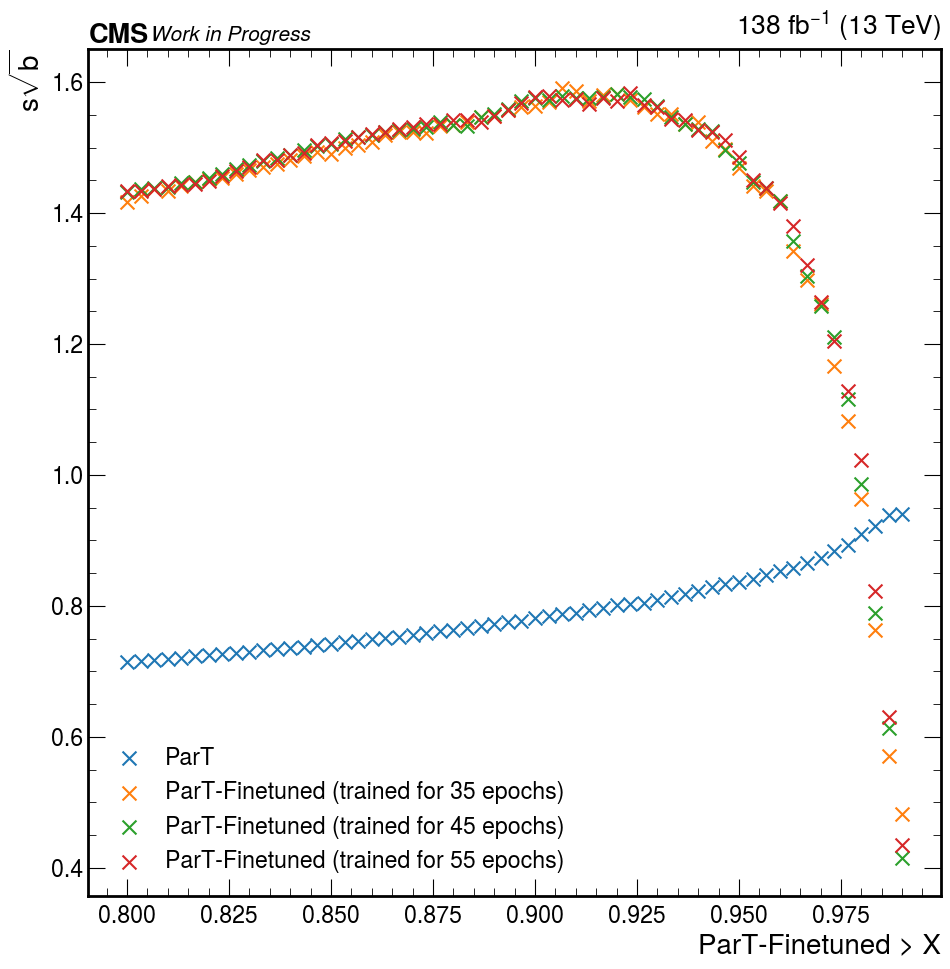

In [249]:
plt.rcParams.update({"font.size": 20})

nice_ch = {
    "ele": "Electron",
    "mu": "Muon",
}

fig, ax = plt.subplots(figsize=(11, 11))

taggers_to_plot = [
    "fj_ParT_score",
#     "fj_ParT_score_finetuned",
#     "fj_ParT_score_finetuned_v35_12_14",
    
#     "fj_ParT_score_finetuned_v35_16",
#     "fj_ParT_score_finetuned_v35_17",
#     "fj_ParT_score_finetuned_v35_20",
    
    "fj_ParT_score_finetuned_v35_23",
    "fj_ParT_score_finetuned_v35_26",
    "fj_ParT_score_finetuned_v35_29",
    
    
]
# taggers_to_plot = taggerss

for tagger in taggers_to_plot:   
    
    
    if tagger == "fj_ParT_score":
        lab = "ParT"
        col = "tab:orange"

    elif tagger == "fj_ParT_score_finetuned":
        lab = "ParT-Finetuned (current)"
        
#     elif tagger == "fj_ParT_score_finetuned_v35_16":
#         lab = "ParT-Finetuned (on 100k Signal)"
#     elif tagger == "fj_ParT_score_finetuned_v35_17":
#         lab = "ParT-Finetuned (on 100k Signal)"
#     elif tagger == "fj_ParT_score_finetuned_v35_18":
#         lab = "ParT-Finetuned (on 200k Signal)"
#     elif tagger == "fj_ParT_score_finetuned_v35_19":
#         lab = "ParT-Finetuned (on 200k Signal)"
        
#     elif tagger == "fj_ParT_score_finetuned_v35_20":
#         lab = "ParT-Finetuned (trained for 25 epochs)"
    elif tagger == "fj_ParT_score_finetuned_v35_23":
        lab = "ParT-Finetuned (trained for 35 epochs)"
    elif tagger == "fj_ParT_score_finetuned_v35_26":
        lab = "ParT-Finetuned (trained for 45 epochs)"
    elif tagger == "fj_ParT_score_finetuned_v35_29":
        lab = "ParT-Finetuned (trained for 55 epochs)"

    
    elif tagger == "fj_ParT_score_finetuned_v35_12_14 metcut":
        lab = "ParT-Finetuned (after MET cuts)"        
        
    else:
        lab = tagger
        col = "tab:blue"
        
    
    ax.scatter(tagger_cuts[:-3], s_over_b[tagger], marker="x", s=100, label=lab)#, c=col)

if len(channels)==1:
    lab = f"{nice_ch[channels[0]]} channel"
    if add_vbfcut:
        lab += " (VBF category)"
    if add_ggFcut:
        lab += " (ggF category)"        
    ax.legend(title=lab, loc="lower left")    
else:
    if add_vbfcut:
        lab = "VBF category"
    elif add_ggFcut:
        lab = "ggF category"
    else:
        lab = ""
    ax.legend(title=lab, loc="lower left")
ax.set_ylabel(r"$s\sqrt{b}$")
ax.set_xlabel("ParT-Finetuned > X")

# ax.axvline(0.895, linestyle="--", color="grey")
# ax.axvline(0.924, linestyle="--", color="grey")
# ax.axvline(0.91, linestyle="--", color="grey")
# ax.axvline(0.92, linestyle="--", color="grey")

# ax.set_ylim(0.5,2)
# ax.set_ylim(0.2,1.1)
# ax.set_xlim(0.78,0.95)

# ax.set_xticks(tagger_cuts)
hep.cms.lumitext("%.0f " % get_lumi(years, channels) + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15);
plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/soverb-new.pdf")

In [74]:
def fix_neg_yields(h):
    """
    Will set the bin yields of a process to 0 if the nominal yield is negative, and will
    set the yield to 0 for the full Systematic axis.
    """
    for sample in h.axes["samples"]:
        neg_bins = np.where(h[{"samples": sample}].values() < 0)[0]

        if len(neg_bins) > 0:
            print(f"{sample}, has {len(neg_bins)} bins with negative yield.. will set them to 0")

            sample_index = np.argmax(np.array(h.axes["samples"]) == sample)

            for neg_bin in neg_bins:
                h.view(flow=True)[sample_index, neg_bin + 1] = (0, 0)

In [213]:
vars_to_plot = [
#     "fj_msoftdrop",        
#     "rec_W_lnu_m",
#     "fj_pt",
#     "lep_pt",
#     "lep_eta",
    
#     "lep_fj_dr",
#     "lep_met_mt",
#     "met_fj_dphi",
#     "met_pt",    
    
#     "btag_1a",
#     "0btag_1b",
#     "1pbtag_1b",
    
#     "0btagT_btagSF",
#     "1plusbtagT_btagSF"
    
#     "rec_higgs_etajet_m",
#     "fj_ParT_mass",
#     "fj_ParT_score_finetuned"
    
    "rec_higgs_m",    
    # AN
#     "FirstFatjet_pt",
#     "SecondFatjet_pt",
#     "fj_pt",
#     "lep_pt",
#     "NumFatjets",
#     "NumOtherJets",
#     "lep_fj_dr",
#     "met_pt",
#     "met_fj_dphi",
#     "lep_met_mt",    
#     "ht",
#     "fj_mass",
#     "rec_W_qq_m",
#     "rec_W_lnu_m",    
#     "fj_lsf3",
    
#     "lep_isolation",
#     "lep_isolation_ele",
#     "lep_isolation_ele_highpt",
#     "lep_isolation_ele_lowpt",
    
#     "lep_isolation_mu",
#     "lep_isolation_mu_highpt",
#     "lep_isolation_mu_lowpt",   
    
#     "lep_misolation",
#     "lep_misolation_highpt",
#     "lep_misolation_lowpt",    
]

samples_to_plot = [
    "ggF", 
    "VBF",
#     "ttH",
#     "WH",
#     "ZH",    
    "QCD",
#     "DYJets",
    "WJetsLNu",
    
#     "WJetsLNu_unmatched",
#     "WJetsLNu_matched",

#     "WZQQ",
    "TTbar",
    "SingleTop",
    "Diboson",
    "EWKvjets",
    "Data",
    
    "WZQQorDYJets"
]

In [214]:
# tagger = "fj_ParT_score"
# tagger = "fj_ParT_score_finetuned"
# tagger_cut = 0.97   # VBF
# tagger_cut = 0.975  # ggF

tagger = "fj_ParT_score_finetuned_v35_12_14"
tagger = "fj_ParT_score_finetuned_v35_20"

# tagger_cut = 0.88   # VBF
tagger_cut = 0.91  # ggF

# tagger_cut = 0.895  # ggF

presel = {
#     "Pre-selection": f"fj_pt>0",   # dummy
    "SR": f"({tagger}>{tagger_cut}) & (n_bjets_T==0)",   # dummy
    
#     "SR": f"{tagger}>0.965",
#     "SR": f"{tagger}>{tagger_cut}",    
    
#     "Pre-selection": f"(fj_ParT_score_finetuned>0.95) & (fj_msoftdrop>10)",   # dummy    
    
#     "Pre-selection": f"met_pt>100 & ({tagger}<0.5) & n_bjets_T>0",   # dummy    
#     "Pre-selection": f"met_pt>100 & n_bjets_T>0",   # dummy    

#     "Pre-selection": f"met_pt>100 & n_bjets_L==0 & {tagger}>0.5 & {tagger}<0.97",   # dummy    
    
#     "Pre-selection": f"met_pt>20",

#     "SR": f"({tagger}>0.98) & (n_bjets_T==0)",    
    
#     "SR2": f"({tagger}>0.97) & ({tagger}<0.98) & (n_bjets_T==0)",
#     "WJets CR": f"({tagger}<0.88) & ({tagger}>0.70) & (n_bjets_T==0) & (met_pt>100)",
#     "Top CR": f"({tagger}>0.8) & (n_bjets_T>0)",
}

categories_sel = {
#     "VBF": f"( (fj_ParT_score_finetuned>{tagger_cut}) & (n_bjets_T==0) ) & ( (mjj>1000) & (deta>3.5) )",
#     rf"ggF": "(mjj<1000) | (deta<3.5)",
        
#     r"ggF pT [250, 300]": f"( (fj_ParT_score_finetuned>{tagger_cut}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (fj_pt>250) & (fj_pt<300) )",
#     f"ggF pT [300, 450]": f"( (fj_ParT_score_finetuned>{tagger_cut}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (fj_pt>300) & (fj_pt<450) )",
#     r"ggF pT [450, Inf]": f"( (fj_ParT_score_finetuned>{tagger_cut}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (fj_pt>450) )",
}

channels = ["ele", "mu"]
# channels = ["mu"]
years = ["2018", "2017", "2016", "2016APV"]
years = ["2018"]

num, den = 0, 0
threshold = 0

# fill histograms
hists = {}

# ev = events_dict["new_correctionsNOTAGGER"]

ev = events_dict
# ev = events_dict["wjetsNLO"]

# ev = events_dict["new_correctionsNODPHI"]

MET_cut = False
import utils

massbin = 10
if "VBF" in categories_sel:
    massbin = 20

for var in vars_to_plot:

    if var == "rec_higgs_m":
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            hist2.axis.Variable(list(range(55, 255, massbin)), name="var", label=r"Higgs reconstructed mass [GeV]", overflow=True),
            storage=hist2.storage.Weight(),            
        )       
    else:
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            utils.axis_dict[var],
            storage=hist2.storage.Weight(),            
        )        
        
    for sample in samples_to_plot:
        for year in years:
            for ch in channels:
            
                region, sel = list(presel.items())[0]
                
                df = ev[year][ch][sample]
                
                df = df.query(sel)
                    
                if "MET>X" in region:
                    MET_cut = 100
                    df = df[df["met_pt"]>MET_cut]
                                
                if len(categories_sel)>=1:
                    category, category_sel = list(categories_sel.items())[0]
                    df = df.query(category_sel)
            
                if sample == "QCD":
                    threshold = 30
                    den += len(df['event_weight'])
                    num += sum(df["event_weight"]>threshold)

                    df = df[df["event_weight"] < threshold]
                
                x = df[var]
                w = df["event_weight"]
                
                hists[var].fill(
                    samples=sample,
                    var=x,
                    weight=w,
                )     
try:
    print(f"Removing {num} out of {den} qcd events by applying event_weight<{threshold} ({(100*num/den):.2f}%)")
except:
    z=1
    
for var in vars_to_plot:
    fix_neg_yields(hists[var])

Removing 0 out of 11 qcd events by applying event_weight<30 (0.00%)
WZQQorDYJets, has 1 bins with negative yield.. will set them to 0


Will plot rec_higgs_m histogram


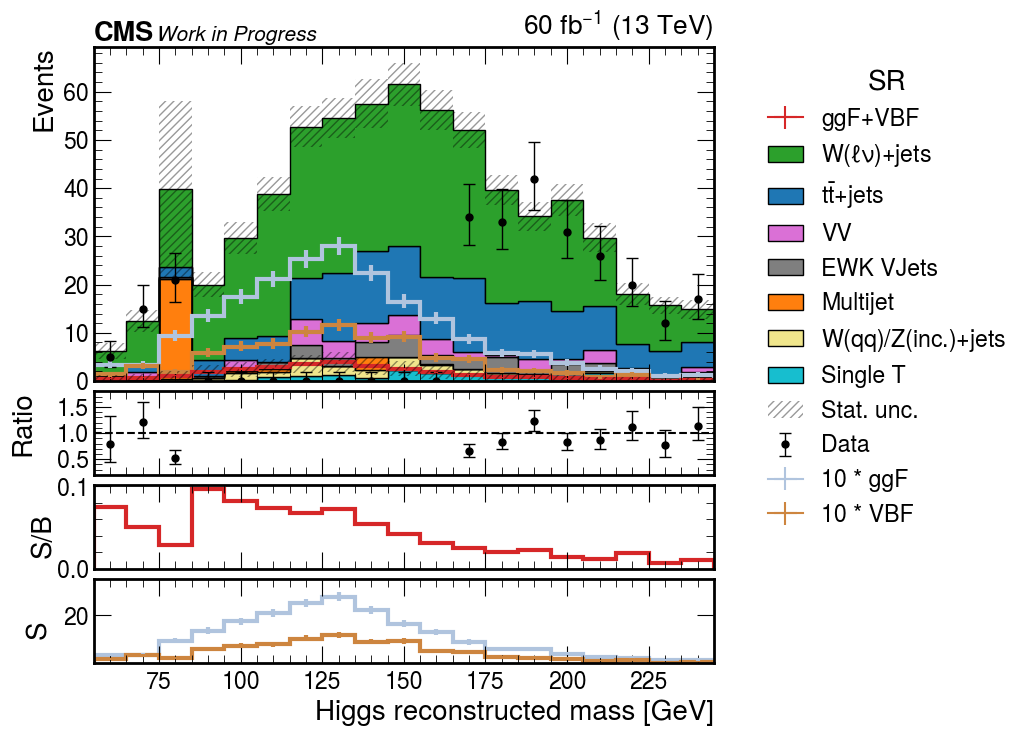

In [215]:
plt.rcParams.update({"font.size": 20})
add_data = True

if "SR" in region or ("Signal region") in region:
    add_soverb=True
    blind_region=[90,160]
    if "SR1" in region:
        mult=10
    else:
        mult=10
else:
    add_soverb=True
    blind_region=False
    mult=10
    
if "VBF" in categories_sel:
    mult = 5
    
    
from utils import plot_hists
if len(years) > 1:
    from utils import plot_hists
    PATH = f"/Users/fmokhtar/Desktop/AN_2024/preselection_Run2/"
    PATH = f"/Users/fmokhtar/Desktop/AN_2024/SignalRegion/"

#     PATH = f"/Users/fmokhtar/Desktop/AN_2024/sig_region_{list(categories_sel.keys())[0]}_Run2/"
else:
    from utils import plot_hists_sb as plot_hists
    PATH = f"/Users/fmokhtar/Desktop/AN_2024/preselection_{years[0]}/"
#     PATH = f"/Users/fmokhtar/Desktop/AN_2024/sig_region_{list(categories_sel.keys())[0]}_{years[0]}/"

PATH = f"/Users/fmokhtar/Desktop/AN_2024/lol/"
# from utilsF import plot_hists

if not os.path.exists(PATH):
    # Create the directory
    os.makedirs(PATH)    

plot_hists(hists, years, channels, vars_to_plot,             
            add_data=add_data,
            logy=False,
            add_soverb=add_soverb,
            only_sig=False,
            mult=mult,
            outpath=PATH,
            text_=region,
#             text_=region + f"\n {list(categories_sel.keys())[0]} category",
#             text_=region + f"\n category: {list(categories_sel.keys())[0]} \n Applying qcd event_weight<{threshold}",
#             text_=region + f"\n Applying qcd event_weight<{threshold}",

            blind_region=blind_region,
#            save_as=f"{years[0]}_{channels[0]}"
#            save_as=f"{ch}"
           
          )
# print()
# get_soverb(ev, tagger, presel, categories_sel, years, channels, threshold=threshold, MET_cut=MET_cut)

In [64]:
hists

{'rec_higgs_m': Hist(
   StrCategory(['ggF', 'VBF', 'ttH', 'WH', 'ZH', 'QCD', 'WJetsLNu', 'TTbar', 'SingleTop', 'Diboson', 'EWKvjets', 'Data', 'WZQQorDYJets'], growth=True, name='samples'),
   Variable([45, 55, 65, 75, 85, 95, 105, 115, 125, 135, 145, 155, 165, 175, 185, 195, 205, 215, 225, 235], name='var', label='Higgs reconstructed mass [GeV]'),
   storage=Double()) # Sum: 1038.332692342047 (1172.7765295977254 with flow)}

In [298]:
hists["rec_higgs_m"][{"samples": sum}].values()[0:2]

array([0.13706524, 2.00155444])

In [463]:
# VBFele + VBFmu + ggF_ele + ggF_mu
(0.75**2 + 1.13**2 + 0.68**2 + 1.02**2)**0.5

1.8281684823888633

In [464]:
# VBF + ggF
(1.35**2 + 1.21**2)**0.5

1.81289823211343

In [471]:
(0.82**2 + 1.24**2)**0.5

1.4866068747318506

In [89]:
dominant_backgrounds = ["WJetsLNu", "TTbar", "QCD", "WZQQorDYJets"]
def get_soverb(ev, tagger, presel, categories_sel, years, channels, MET_cut=False, misocut=None, threshold=None):

    mass_window = [100, 150]

    num_sig = {
        "ggF": 0, 
#         "ttH": 0, 
#         "VH": 0,
        "VBF": 0,
    }
    num_bkg = {
        "WJetsLNu": 0, 
        "TTbar": 0, 
        "QCD": 0,
        "WZQQorDYJets": 0,
        "Others": 0,
    }

    deno_sig, deno_bkg = 0, 0
    s, b = 0, 0

    samples = [
        "ggF", 
        "VBF",
        "ttH",
        "WH",
        "ZH",        
        "QCD",
#         "DYJets",
        "WJetsLNu",
#         "WZQQ",
        "TTbar",
        "SingleTop",
        "Diboson",
        "Data",
        "WZQQorDYJets",
    ]

    for year in years:
        for ch in channels:
            for sample in samples:
                if sample=="Data":
                    continue

                region, sel = list(presel.items())[0]

                df = ev[year][ch][sample]

                df = df.query(sel)  

                for category, category_sel in categories_sel.items():
                    df = df.query(category_sel)

                if MET_cut:
                    df = df[df["met_pt"]>MET_cut]
                    
                if threshold:
                    if sample == "QCD":
                        df = df[df["event_weight"] < threshold]
    
                ######################## composition start
                if sample in utils.signals:

                    deno_sig += df["event_weight"].sum()
                    num_sig[sample] += df["event_weight"].sum()
                else:
                    deno_bkg += df["event_weight"].sum()

                    if sample in dominant_backgrounds:
                        num_bkg[sample] += df["event_weight"].sum()
                    else:
                        num_bkg["Others"] += df["event_weight"].sum()     
                ######################## composition end

                ######################## soverb start
                df = df[(df["rec_higgs_m"]>=mass_window[0]) & (df["rec_higgs_m"]<=mass_window[1])]

                if sample in utils.signals:                
                    s += df["event_weight"].sum()
                else:
                    b += df["event_weight"].sum()
                ######################## soverb end

    num_sig = dict(sorted(num_sig.items(), key=lambda item: item[1]))
    num_bkg = dict(sorted(num_bkg.items(), key=lambda item: item[1]))

    if len(years) == 4:
        lab = "RUN2"
    else:
        lab = "_".join(years)

    print("\033[1m" + f"{list(presel.keys())[0]} ({lab}):" + '\033[0m')
    if len(list(categories_sel.items()))!=0:
        print("Category:", list(categories_sel.keys())[0])

    print("------------------------")

    if "SR" in list(presel.keys())[0]:
        print("\033[1m" + rf"s/sqrt(b) in [{mass_window[0]},{mass_window[1]}]: {s/math.sqrt(b):.2f}" + '\033[0m')
        print("------------------------")

    print(f"Signal: {deno_sig:.2f}")
    for sample in num_sig:
        print(f"- {sample}: {100*(num_sig[sample]/deno_sig):.0f}%")

    print("------------------------")
    print(f"Background: {deno_bkg:.2f}")
    for sample in num_bkg:
        if sample=="":
            print("\033[1m" + f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%")
        else:
            print(f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%")             

In [ ]:
fig, ax = plt.subplots(figsize=(9,8))

bins = np.linspace(45,210,20)

syst = "UES_down"


a = ax.hist(df["rec_higgs_m"], label="Nominal", weights=df["weight_ele"],
        bins=bins, lw=2, histtype="step", 
       )

d = ax.hist(df[f"rec_higgs_m{syst}"], label="down", weights=df["weight_ele"],
        bins=bins, lw=2, histtype="step", 
       )

# w = (df[f"rec_higgs_m{syst}"]/df["rec_higgs_m"])
# ax.hist(df[f"rec_higgs_m"], label="(should be down)", weights=df["weight_ele"] * w,
#         bins=bins, lw=1, histtype="step", 
#        )

ax.legend()
ax.set_xlabel("Higgs reconstructed mass [GeV]")
ax.set_ylabel("ggHWW events")
#         plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/JMSR/weight_{ch}_{syst}.pdf")